<a href="https://colab.research.google.com/github/amitkbiswas0/ocr-cnn/blob/master/ocr_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os, glob
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils import np_utils, plot_model
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, Dropout, Dense, Flatten, BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
np.random.seed(0)
# data plotting
get_ipython().run_line_magic('matplotlib', 'inline')
sns.set(style='white', context='notebook', palette='deep')

In [9]:
# change directory to dataset folder
path = '/content/drive/My Drive/Colab Notebooks/data/'
os.chdir(path)
# concat all the csv files in one dataframe
extension_name = "csv"
all_files = [i for i in glob.glob("*.{}".format(extension_name))]
dataframe = pd.concat([pd.read_csv(f) for f in all_files])
print(dataframe.shape)

(366487, 785)


In [10]:
# separate dataframe into label and features
label = dataframe[["label"]].copy()
dataframe.pop("label")
features = dataframe
print(features.shape, label.shape)

(366487, 784) (366487, 1)


In [11]:
# separate label and features into train and test set
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.25, shuffle=True)
print(f'Train size: {x_train.shape}')
print(f'Test size: {x_test.shape}')

Train size: (274865, 784)
Test size: (91622, 784)


In [0]:
# fit and transform train data between 0-1
# for easier computation using min max scaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [13]:
# normalize data to avoid anomolies
# one hot encoding
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
print(y_train.shape, y_test.shape)
print(x_train.shape, x_test.shape)

(274865, 122) (91622, 122)
(274865, 784) (91622, 784)


In [14]:
# change into 28*28 matrix
x_train = np.reshape(x_train, (-1,28,28,1))
x_test = np.reshape(x_test, (-1,28,28,1))
print(x_train.shape)
print(x_test.shape)

(274865, 28, 28, 1)
(91622, 28, 28, 1)


In [29]:
# input layer
visible = Input(shape=(28,28,1))

# first 2 conv2d
layer_1 = Conv2D(32, kernel_size=3, padding="same", activation='relu')(visible)
layer_2 = Conv2D(32, kernel_size=5, padding="same", activation="relu")(layer_1)
layer_3 = MaxPooling2D(pool_size=(2,2))(layer_2)
layer_4 = Dropout(rate=0.25)(layer_3)

# parallel part
# top layers
layer_5 = Conv2D(64, kernel_size=5, padding="same", activation="relu")(layer_4)
layer_6 = BatchNormalization()(layer_5)
layer_7 = Conv2D(64, kernel_size=5, padding="same", activation="relu")(layer_6)
layer_8 = BatchNormalization()(layer_7)
layer_9 = MaxPooling2D(pool_size=(2,2))(layer_8)
layer_10 = Dropout(rate=0.25)(layer_9)
# bottom layers
layer_11 = Conv2D(64, kernel_size=3, padding="same", activation="relu")(layer_4)
layer_12 = Conv2D(64, kernel_size=3, padding="same", activation="relu")(layer_11)
layer_13 = MaxPooling2D(pool_size=(2,2))(layer_12)
layer_14 = Dropout(rate=0.25)(layer_13)

# last part
layer_15 = concatenate([layer_10, layer_14])
layer_16 = Conv2D(64, kernel_size=3, padding="same", activation="relu")(layer_15)
layer_17 = MaxPooling2D(pool_size=(2,2))(layer_16)
layer_18 = Dropout(rate=0.25)(layer_17)

# rest
flatten = Flatten()(layer_18)
hidden = Dense(2048, activation="relu")(flatten)
layer_19 = Dropout(rate=0.25)(hidden)
output = Dense(122, activation="softmax")(layer_19)
model = Model(inputs=visible, outputs=output)

model.save('ocr_cnn.h5')
optimizer = Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 32)   25632       conv2d_8[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 14, 14, 32)   0           conv2d_9[0][0]                   
____________________________________________________________________________________________

In [0]:
model_chkpt = ModelCheckpoint('best_mod.h5', save_best_only=True, monitor='accuracy')
early_stopping = EarlyStopping(monitor='loss', restore_best_weights=False, patience=10)

In [31]:
training_history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=128, callbacks=[model_chkpt, early_stopping])
model.save('ocr_cnn_trained.h5')

Train on 274865 samples, validate on 91622 samples
Epoch 1/10
274865/274865 [==============================] - 3608s 13ms/step - loss: 0.8101 - accuracy: 0.7894 - val_loss: 0.3090 - val_accuracy: 0.9193
Epoch 2/10
274865/274865 [==============================] - 3596s 13ms/step - loss: 0.3601 - accuracy: 0.9031 - val_loss: 0.2698 - val_accuracy: 0.9308
Epoch 3/10
274865/274865 [==============================] - 3604s 13ms/step - loss: 0.3004 - accuracy: 0.9197 - val_loss: 0.2165 - val_accuracy: 0.9448
Epoch 4/10
274865/274865 [==============================] - 3609s 13ms/step - loss: 0.2645 - accuracy: 0.9285 - val_loss: 0.2022 - val_accuracy: 0.9499
Epoch 5/10
274865/274865 [==============================] - 3613s 13ms/step - loss: 0.2332 - accuracy: 0.9365 - val_loss: 0.2201 - val_accuracy: 0.9441
Epoch 6/10
274865/274865 [==============================] - 3657s 13ms/step - loss: 0.2128 - accuracy: 0.9420 - val_loss: 0.1866 - val_accuracy: 0.9531
Epoch 7/10
274865/274865 [===========

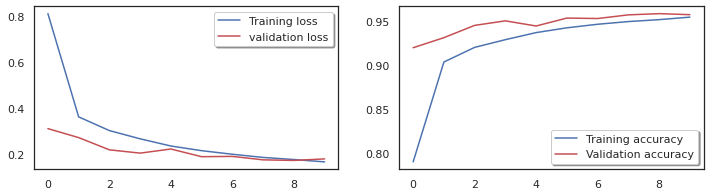

In [32]:
fig, ax = plt.subplots(1,2, figsize=(12, 3))
ax[0].plot(training_history.history['loss'], color='b', label="Training loss")
ax[0].plot(training_history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(training_history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(training_history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)